## class rbc_env

In [12]:
%pip install gymnasium
%pip install abc
%pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://artifactory.tcsbank.ru/artifactory/api/pypi/python-all/simple

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://artifactory.tcsbank.ru/artifactory/api/pypi/python-all/simple
ERROR: Could not find a version that satisfies the requirement abc (from versions: none)
ERROR: No matching distribution found for abc

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://artifactory.tcsbank.ru/artifactory/api/pypi/pytho

In [7]:
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import gymnasium as gym
from typing import (
    Optional,
    Dict,
    Tuple,
    Union,
)

import gymnasium as gym
import numpy as np
from abc import (
    ABC,
    abstractmethod,
)
from typing import (
    Optional,
    Dict,
    Tuple,
    Union,
)

class AbstractEconomicEnv(gym.Env, ABC):
    """
    Abstract base class for an economic environment.
    This class defines the necessary methods that any economic environment must implement.
    """

    @abstractmethod
    def __init__(self, **kwargs):
        super().__init__()

    @abstractmethod
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[Dict, Dict]:
        """
        Reset the environment to initial state.

        :param seed: Random seed for reproducibility
        :param options: Additional options for reset (unused)
        :return: Initial state observation and empty info dictionary
        """
        pass

    @abstractmethod
    def step(self, action: np.ndarray) -> Tuple[Dict, float, bool, bool, Dict]:
        """
        Execute one time step of the economic model.

        :param action: Array of action variables
        :return: Tuple containing:
                - state: Dictionary of current state variables
                - reward: Utility value for current period
                - terminated: Whether episode has ended
                - truncated: Whether episode was truncated
                - info: Dictionary with additional information
        """
        pass

    @abstractmethod
    def render(self):
        """
        Display current state of the environment.
        """
        pass

    @abstractmethod
    def close(self):
        """Clean up resources"""
        pass

    @abstractmethod
    def analytical_step(self) -> Tuple[Dict, float, bool, bool, Dict]:
        """
        Calculate the analytical solution for the economic model for one time step.

        :return: Tuple containing:
                - state: Dictionary of current state variables
                - reward: Utility value for current period
                - terminated: Whether episode has ended
                - truncated: Whether episode was truncated
                - info: Dictionary with additional information
        """
        pass

    @property
    @abstractmethod
    def params(self) -> Dict[str, Union[float, str, dict]]:
        """
        Get the current parameters of the economic environment.

        :return: Dictionary containing the current parameters of the environment
        """
        pass

    @property
    @abstractmethod
    def state_description(self):
        """
        Provide descriptions of state variables.

        :return: Dictionary mapping state variable names to their descriptions
        """
        pass

    @property
    @abstractmethod
    def action_description(self):
        """
        Provide descriptions of action variables.

        :return: Dictionary mapping action variable names to their descriptions
        """
        pass


class RBCEnv(AbstractEconomicEnv):
    """
    A Real Business Cycle (RBC) environment implementing a standard RBC model.
    The agent acts as a representative consumer-worker making decisions about
    consumption, investment, and labor supply.

    State Space:
        - Capital: Current capital stock
        - Labor: Labor supply (1 - leisure)
        - Technology: Technology level (in logs)
        - Output: Current period output

    Action Space:
        - Investment rate: Fraction of output for investment
        - Leisure: Time allocated to leisure
        - Consumption rate: Fraction of output for consumption

    :param discount_rate: Time preference parameter (discount factor in RL), defaults to 0.99
    :param marginal_disutility_of_labor: Weight on leisure in utility, defaults to 1.0
    :param depreciation_rate: Capital depreciation rate, defaults to 0.025
    :param capital_share_of_output: Capital share in production function, defaults to 0.36
    :param technology_shock_persistence: AR(1) coefficient for technology, defaults to 0.95
    :param technology_shock_variance: Variance of technology innovations, defaults to 0.007
    :param initial_capital: Starting capital stock, defaults to 1.0
    :param max_capital: Upper bound on capital stock, defaults to 10.0
    :param utility_function: Type of utility function ('log' or 'ces'), defaults to 'log'
    :param utility_params: Dictionary of utility function parameters
    """

    def __init__(
            self,
            discount_rate: float = 0.99,
            marginal_disutility_of_labor: float = 1.0,
            depreciation_rate: float = 0.025,
            capital_share_of_output: float = 0.36,
            technology_shock_persistence: float = 0.95,
            technology_shock_variance: float = 0.007,
            initial_capital: float = 1.0,
            max_capital: float = 10.0,
            utility_function: str = "log",
            utility_params: dict = None,
    ):
        super().__init__()

        self.discount_rate = discount_rate
        self.marginal_disutility_of_labor = marginal_disutility_of_labor
        self.depreciation_rate = depreciation_rate
        self.capital_share_of_output = capital_share_of_output
        self.technology_shock_persistence = technology_shock_persistence
        self.technology_shock_variance = technology_shock_variance
        self.initial_capital = initial_capital
        self.max_capital = max_capital

        # Set utility function and its parameters
        self._set_utility_function(utility_function, utility_params or {})

        self.observation_space = gym.spaces.Dict(
            {
                "Capital": gym.spaces.Box(low=0.0, high=max_capital, shape=(1,), dtype=np.float32),
                "Labor": gym.spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
                "Technology": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
                "Output": gym.spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
            }
        )

        self.action_space = gym.spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([1, 1, 1]),
            dtype=np.float32,
        )

        self._map_action_to_name = {
            0: "leisure",
            1: "consumption",
            2: "investment",
        }

    def _set_utility_function(self, utility_function: str, utility_params: dict):
        """
        Configure the utility function and its parameters for the RBC model.

        :param utility_function: Type of utility function ('log' or 'ces')
        :param utility_params: Dictionary of parameters for the utility function
        :raises ValueError: If utility_function is not 'log' or 'ces'
        """
        self.utility_params = utility_params

        if utility_function.lower() == "log":
            self.utility_function = log_utility
            self.utility_params.setdefault('A', self.marginal_disutility_of_labor)

        elif utility_function.lower() == "ces":
            self.utility_function = ces_utility
            # Set default parameters if not provided
            self.utility_params.setdefault('sigma', 2.0)
            self.utility_params.setdefault('eta', 1.5)
            self.utility_params.setdefault('A', self.marginal_disutility_of_labor)

        else:
            raise ValueError(f"Unknown utility function: {utility_function}. Choose 'log' or 'ces'")

    def calculate_utility(
            self, consumption: Union[float, np.ndarray], labor: Union[float, np.ndarray]
    ) -> Union[float, np.ndarray]:
        """
        Calculate the utility value for given consumption and labor choices.

        :param consumption: Consumption level, must be positive
        :param labor: Labor supply, must be between 0 and 1
        :return: Utility value based on the configured utility function
        """
        return self.utility_function(C=consumption, L=labor, **self.utility_params)

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[Dict, Dict]:
        """
        Reset the environment to initial state.

        :param seed: Random seed for reproducibility
        :param options: Additional options for reset (unused)
        :return: Initial state observation and empty info dictionary
        """
        super().reset(seed=seed)

        self.current_step = 0
        self.capital = self.initial_capital
        self.technology = 0.0  # Initial technology level (log)
        self.labor = 0.5  # Initial labor supply
        self.output = self._calculate_output()

        return self._get_state(), {}

    def _get_state(self) -> Dict:
        """
        Construct the current state observation dictionary.

        :return: Dictionary containing current values of all state variables
        """
        return {
            "Capital": np.array([self.capital], dtype=np.float32),
            "Labor": np.array([self.labor], dtype=np.float32),
            "Technology": np.array([self.technology], dtype=np.float32),
            "Output": np.array([self.output], dtype=np.float32),
        }

    def _calculate_output(self) -> float:
        """
        Calculate output using Cobb-Douglas production function.
        Y = A * K^α * L^(1-α)

        :return: Current period output
        """
        return np.exp(self.technology) * (self.capital ** self.capital_share_of_output) * \
            (self.labor ** (1 - self.capital_share_of_output))

    def step(self, action: np.ndarray) -> Tuple[Dict, float, bool, bool, Dict]:
        """
        Execute one time step of the RBC model.

        :param action: Array of [investment_rate, leisure, consumption_rate]
                      Each component must be between 0 and 1
        :return: Tuple containing:
                - state: Dictionary of current state variables
                - reward: Utility value for current period
                - terminated: Whether episode has ended (always False)
                - truncated: Whether episode was truncated (always False)
                - info: Dictionary with additional information
        """
        # Clip leisure between 0 and 1
        # TODO(aponomarev): think about clipping
        leisure = np.clip(action[1], 0, 1)

        # Normalize only investment and consumption rates to sum to 1
        investment_consumption = np.clip(action[[0, 2]], 0, 1)
        investment_consumption = investment_consumption / np.sum(investment_consumption)

        investment_rate, consumption_rate = investment_consumption

        # Calculate labor supply (1 - leisure)
        new_labor = 1 - leisure

        # Update technology shock
        technology_shock = np.random.normal(0, self.technology_shock_variance)
        new_technology = (self.technology_shock_persistence * self.technology
                          + technology_shock)

        # Calculate current output
        current_output = self._calculate_output()

        # Calculate investment and consumption
        investment = investment_rate * current_output
        consumption = consumption_rate * current_output

        # Update capital stock
        new_capital = (1 - self.depreciation_rate) * self.capital + investment
        new_capital = np.clip(new_capital, 0, self.max_capital)

        # Store new state
        self.capital = new_capital
        self.labor = new_labor
        self.technology = new_technology
        self.output = self._calculate_output()

        # Calculate reward (utility)
        reward = self.calculate_utility(consumption, new_labor)

        # Check if episode should terminate
        self.current_step += 1
        done = False  # RBC models typically run indefinitely - there's no natural endpoint to the economic simulation

        # Additional information
        info = {
            "investment": investment,
            "consumption": consumption,
            "utility": reward,
            "output": current_output
        }

        return self._get_state(), reward, done, False, info

    def analytical_step(self) -> Tuple[Dict, float, bool, bool, Dict]:
        """
        Calculate the analytical solution for the RBC model for one time step.

        :return: Tuple containing:
                - state: Dictionary of current state variables
                - reward: Utility value for current period
                - terminated: Whether episode has ended (always False)
                - truncated: Whether episode was truncated (always False)
                - info: Dictionary with additional information
        """
        # todo: revise code
        # Define parameters
        alpha = self.capital_share_of_output
        beta = self.discount_rate
        delta = self.depreciation_rate
        A = np.exp(self.technology)

        # Calculate steady-state values
        steady_state_labor = (1 - alpha) / (1 - alpha + self.marginal_disutility_of_labor)
        steady_state_output = A * (self.capital ** alpha) * (steady_state_labor ** (1 - alpha))
        steady_state_consumption = np.clip(steady_state_output - delta * self.capital, a_min=0, a_max=None)
        steady_state_investment = delta * self.capital

        # Update technology shock
        technology_shock = np.random.normal(0, self.technology_shock_variance)
        new_technology = self.technology_shock_persistence * self.technology + technology_shock

        # Calculate new state variables
        new_capital = (1 - delta) * self.capital + steady_state_investment
        new_capital = np.clip(new_capital, 0, self.max_capital)
        new_labor = steady_state_labor
        new_output = np.exp(new_technology) * (new_capital ** alpha) * (new_labor ** (1 - alpha))

        # Calculate reward (utility)
        reward = self.calculate_utility(steady_state_consumption, new_labor)

        # Update the state
        self.capital = new_capital
        self.labor = new_labor
        self.technology = new_technology
        self.output = new_output

        # Check if episode should terminate
        self.current_step += 1
        done = False  # RBC models typically run indefinitely - there's no natural endpoint to the economic simulation

        # Get actions array
        leisure = 1 - steady_state_labor
        consumption_rate = steady_state_consumption / steady_state_output if steady_state_output > 0 else 0
        investment_rate = steady_state_investment / steady_state_output if steady_state_output > 0 else 0

        # Normalize investment and consumption rates to sum to 1
        total_rate = consumption_rate + investment_rate
        if total_rate > 0:
            consumption_rate = consumption_rate / total_rate
            investment_rate = investment_rate / total_rate

        # Create action array matching the action space structure
        action = [leisure, consumption_rate, investment_rate]

        # Additional information
        # todo: add pydantic validation
        info = {
            "action": action,
            "investment": steady_state_investment,
            "consumption": steady_state_consumption,
            "utility": reward,
            "output": new_output,
        }

        return self._get_state(), reward, done, False, info

    def render(self):
        """
        Display current state of the environment.
        Prints all state variables with 4 decimal precision.
        """
        state = self._get_state()
        print("\nCurrent State:")
        for key, value in state.items():
            print(f"{key}: {value[0]:.4f}")

    def close(self):
        """Clean up resources"""
        # included for compatibility with the Gymnasium API
        pass

    @property
    def params(self) -> Dict[str, Union[float, str, dict]]:
        """
        Get the current parameters of the RBC environment.

        :return: Dictionary containing the current parameters of the environment
        """
        return {
            "discount_rate": self.discount_rate,
            "marginal_disutility_of_labor": self.marginal_disutility_of_labor,
            "depreciation_rate": self.depreciation_rate,
            "capital_share_of_output": self.capital_share_of_output,
            "technology_shock_persistence": self.technology_shock_persistence,
            "technology_shock_variance": self.technology_shock_variance,
            "initial_capital": self.initial_capital,
            "max_capital": self.max_capital,
            "utility_function": self.utility_function.__name__,
            "utility_params": self.utility_params,
        }

    @property
    def state_description(self):
        """
        Provide descriptions of state variables.

        :return: Dictionary mapping state variable names to their descriptions
        """
        return {
            "Capital": "Capital stock",
            "Labor": "Labor supply = (1 - leisure)",
            "Technology": "Technology level (log)",
            "Output": "Current output"
        }

    @property
    def action_description(self):
        """
        Provide descriptions of action variables.

        :return: Dictionary mapping action variable names to their descriptions
        """
        return {
            "leisure": "Time allocated to leisure (zeroth element in array)",
            "consumption_rate": "Fraction of output allocated to consumption (first element in array)",
            "investment_rate": "Fraction of output allocated to investment (second element in array)",
        }
import numpy as np
from typing import Union


def crra(c: float, theta: float = 0.99):
    return (c ** (1 - theta) - 1) / (1 - theta)


def log_utility(C: Union[float, np.array], L: Union[float, np.array], A: float = 1.0) -> Union[float, np.array]:
    """
    Calculate the log utility for consumption and labor in RBC model.
    U(C,L) = ln(C) + A*ln(1-L)

    :param C: consumption, must be positive
    :param L: labor supply, must be between 0 and 1
    :param A: weight on leisure in utility function, defaults to 1.0
    :return: utility value
    """
    if np.any(L >= 1) or np.any(L <= 0):
        raise ValueError("Labor supply must be between 0 and 1")
    if np.any(C <= 0):
        raise ValueError("Consumption must be positive")

    return np.log(C) + A * np.log(1 - L)


def ces_utility(
        C: Union[float, np.array],
        L: Union[float, np.array],
        sigma: float = 2.0,
        eta: float = 1.5,
        A: float = 1.0
) -> Union[float, np.array]:
    """
    Calculate the CES utility for consumption and labor in RBC model.
    U(C,L) = [C^(1-σ)]/(1-σ) + A*[(1-L)^(1-η)]/(1-η)

    :param C: consumption, must be positive
    :param L: labor supply, must be between 0 and 1
    :param sigma: coefficient of relative risk aversion, defaults to 2.0
    :param eta: inverse Frisch elasticity of labor supply, defaults to 1.5
    :param A: weight on leisure in utility function, defaults to 1.0
    :return: utility value
    """
    if np.any(L >= 1) or np.any(L <= 0):
        raise ValueError("Labor supply must be between 0 and 1")
    if np.any(C <= 0):
        raise ValueError("Consumption must be positive")

    consumption_utility = (C ** (1 - sigma)) / (1 - sigma)
    leisure_utility = A * ((1 - L) ** (1 - eta)) / (1 - eta)
    return consumption_utility + leisure_utility

## Main

In [69]:
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import gymnasium as gym
from typing import (
    Optional,
    Dict,
    Tuple,
    Union,
)

class RBCEnv(AbstractEconomicEnv):
    """
    A Real Business Cycle (RBC) environment implementing a standard RBC model.
    The agent acts as a representative consumer-worker making decisions about
    consumption, investment, and labor supply.

    State Space:
        - Capital: Current capital stock
        - Labor: Labor supply (1 - leisure)
        - Technology: Technology level (in logs)
        - Output: Current period output

    Action Space:
        - Investment rate: Fraction of output for investment
        - Leisure: Time allocated to leisure
        - Consumption rate: Fraction of output for consumption

    :param discount_rate: Time preference parameter (discount factor in RL), defaults to 0.99
    :param marginal_disutility_of_labor: Weight on leisure in utility, defaults to 1.0
    :param depreciation_rate: Capital depreciation rate, defaults to 0.025
    :param capital_share_of_output: Capital share in production function, defaults to 0.36
    :param technology_shock_persistence: AR(1) coefficient for technology, defaults to 0.95
    :param technology_shock_variance: Variance of technology innovations, defaults to 0.02
    :param initial_capital: Starting capital stock, defaults to 1.0
    :param utility_function: Type of utility function ('log' or 'ces'), defaults to 'log'
    :param utility_params: Dictionary of utility function parameters
    """

    def __init__(
            self,
            discount_rate: float = 0.95,
            marginal_disutility_of_labor: float = 1.5,
            depreciation_rate: float = 0.025,
            capital_share_of_output: float = 0.4,
            technology_shock_persistence: float = 0.9,
            technology_shock_variance: float = 0.05,
            initial_capital: float = 1.0,
            utility_function: str = "log",
            utility_params: dict = None,
    ):
        super().__init__()

        self.discount_rate = discount_rate
        self.marginal_disutility_of_labor = marginal_disutility_of_labor
        self.depreciation_rate = depreciation_rate
        self.capital_share_of_output = capital_share_of_output
        self.technology_shock_persistence = technology_shock_persistence
        self.technology_shock_variance = technology_shock_variance
        self.initial_capital = initial_capital

        self._set_utility_function(utility_function, utility_params or {})

        self.observation_space = gym.spaces.Dict(
            {
                "Capital": gym.spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "Labor": gym.spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
                "Technology": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
                "Output": gym.spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
            }
        )

        self.action_space = gym.spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([1, 1, 1]),
            dtype=np.float32,
        )

        self._map_action_to_name = {
            0: "leisure",
            1: "consumption",
            2: "investment",
        }

    def _set_utility_function(self, utility_function: str, utility_params: dict):
        """
        Configure the utility function and its parameters for the RBC model.

        :param utility_function: Type of utility function ('log' or 'ces')
        :param utility_params: Dictionary of parameters for the utility function
        :raises ValueError: If utility_function is not 'log' or 'ces'
        """
        self.utility_params = utility_params

        if utility_function.lower() == "log":
            self.utility_function = log_utility
            self.utility_params.setdefault('A', self.marginal_disutility_of_labor)

        elif utility_function.lower() == "ces":
            self.utility_function = ces_utility
            # Set default parameters if not provided
            self.utility_params.setdefault('sigma', 2.0)
            self.utility_params.setdefault('eta', 1.5)
            self.utility_params.setdefault('A', self.marginal_disutility_of_labor)

        else:
            raise ValueError(f"Unknown utility function: {utility_function}. Choose 'log' or 'ces'")

    def calculate_utility(
            self, consumption: Union[float, np.ndarray], labor: Union[float, np.ndarray]
    ) -> Union[float, np.ndarray]:
        """
        Calculate the utility value for given consumption and labor choices.

        :param consumption: Consumption level, must be positive
        :param labor: Labor supply, must be between 0 and 1
        :return: Utility value based on the configured utility function
        """
        return self.utility_function(C=consumption, L=labor, **self.utility_params)

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[Dict, Dict]:
        """
        Reset the environment to initial state.

        :param seed: Random seed for reproducibility
        :param options: Additional options for reset (unused)
        :return: Initial state observation and empty info dictionary
        """
        super().reset(seed=seed)

        self.current_step = 0
        self.capital = self.initial_capital
        self.technology = np.random.normal(0, self.technology_shock_variance)  # Initial technology level with shock
        self.labor = 0.5  # Initial labor supply
        self.output = self._calculate_output()

        return self._get_state(), {}

    def _get_state(self) -> Dict:
        """
        Construct the current state observation dictionary.

        :return: Dictionary containing current values of all state variables
        """
        return {
            "Capital": np.array([self.capital], dtype=np.float32),
            "Labor": np.array([self.labor], dtype=np.float32),
            "Technology": np.array([self.technology], dtype=np.float32),
            "Output": np.array([self.output], dtype=np.float32),
        }

    def _calculate_output(self) -> float:
        """
        Calculate output using Cobb-Douglas production function.
        Y = A * K^α * L^(1-α)

        :return: Current period output
        """
        return np.exp(self.technology) * (self.capital ** self.capital_share_of_output) * \
            (self.labor ** (1 - self.capital_share_of_output))

    def step(self, action: np.ndarray) -> Tuple[Dict, float, bool, bool, Dict]:
        """
        Execute one time step of the RBC model.

        :param action: Array of [investment_rate, leisure, consumption_rate]
                      Each component must be between 0 and 1
        :return: Tuple containing:
                - state: Dictionary of current state variables
                - reward: Utility value for current period
                - terminated: Whether episode has ended (always False)
                - truncated: Whether episode was truncated (always False)
                - info: Dictionary with additional information
        """

        leisure = np.clip(action[1], 0, 1)

        investment_consumption = np.clip(action[[0, 2]], 0, 1)
        total_rate = np.sum(investment_consumption)
        if total_rate > 0:
            investment_consumption = investment_consumption / total_rate

        investment_rate, consumption_rate = investment_consumption
        new_labor = 1 - leisure
        technology_shock = np.random.normal(0, self.technology_shock_variance)
        new_technology = (self.technology_shock_persistence * self.technology
                          + technology_shock)


        current_output = self._calculate_output()
        investment = investment_rate * current_output
        consumption = consumption_rate * current_output

        new_capital = (1 - self.depreciation_rate) * self.capital + investment
        new_capital = max(new_capital, 0)  # Ensure capital does not drop below zero

        self.capital = new_capital
        self.labor = new_labor
        self.technology = new_technology
        self.output = self._calculate_output()

        reward = self.calculate_utility(consumption, new_labor)

        self.current_step += 1
        done = False 

        info = {
            "investment": investment,
            "consumption": consumption,
            "utility": reward,
            "output": current_output
        }

        return self._get_state(), reward, done, False, info

    def analytical_step(self) -> Tuple[Dict, float, bool, bool, Dict]:
        """
        Calculate the analytical solution for the RBC model for one time step.
        
        :return: Tuple containing:
                - state: Dictionary of current state variables
                - reward: Utility value for current period
                - terminated: Whether episode has ended (always False)
                - truncated: Whether episode was truncated (always False)
                - info: Dictionary with additional information
        """

        alpha = self.capital_share_of_output
        beta = self.discount_rate
        delta = self.depreciation_rate
        A = np.exp(self.technology)
    

        steady_state_labor = max(
            (1 - alpha) / (1 - alpha + self.marginal_disutility_of_labor) 
            + np.random.normal(0, 0.01), 0.01
        )
    

        steady_state_output = A * (self.capital ** alpha) * (steady_state_labor ** (1 - alpha))
        steady_state_investment = delta * self.capital + np.random.normal(0, 0.05)
        steady_state_consumption = max(steady_state_output - steady_state_investment, 1e-6)
    

        technology_shock = np.random.normal(0, self.technology_shock_variance * 2)
        new_technology = self.technology_shock_persistence * self.technology + technology_shock
    

        new_capital = max((1 - delta) * self.capital + steady_state_investment + np.random.normal(0, 0.1), 0)
        new_output = np.exp(new_technology) * (new_capital ** alpha) * (steady_state_labor ** (1 - alpha))
    

        reward = self.calculate_utility(steady_state_consumption, steady_state_labor)
    

        self.capital = new_capital
        self.labor = steady_state_labor
        self.technology = new_technology
        self.output = new_output
    

        info = {
            "investment": steady_state_investment,
            "consumption": steady_state_consumption,
            "utility": reward,
            "output": new_output,
        }
    
        return self._get_state(), reward, False, False, info


    def render(self):
        """
        Display current state of the environment.
        Prints all state variables with 4 decimal precision.
        """
        state = self._get_state()
        print("\nCurrent State:")
        for key, value in state.items():
            print(f"{key}: {value[0]:.4f}")

    def close(self):
        """Clean up resources"""
        # included for compatibility with the Gymnasium API
        pass

    @property
    def params(self) -> Dict[str, Union[float, str, dict]]:
        """
        Get the current parameters of the RBC environment.

        :return: Dictionary containing the current parameters of the environment
        """
        return {
            "discount_rate": self.discount_rate,
            "marginal_disutility_of_labor": self.marginal_disutility_of_labor,
            "depreciation_rate": self.depreciation_rate,
            "capital_share_of_output": self.capital_share_of_output,
            "technology_shock_persistence": self.technology_shock_persistence,
            "technology_shock_variance": self.technology_shock_variance,
            "initial_capital": self.initial_capital,
            "utility_function": self.utility_function.__name__,
            "utility_params": self.utility_params,
        }

    @property
    def state_description(self):
        """
        Provide descriptions of state variables.

        :return: Dictionary mapping state variable names to their descriptions
        """
        return {
            "Capital": "Capital stock",
            "Labor": "Labor supply = (1 - leisure)",
            "Technology": "Technology level (log)",
            "Output": "Current output"
        }

    @property
    def action_description(self):
        """
        Provide descriptions of action variables.

        :return: Dictionary mapping action variable names to their descriptions
        """
        return {
            "leisure": "Time allocated to leisure (zeroth element in array)",
            "consumption_rate": "Fraction of output allocated to consumption (first element in array)",
            "investment_rate": "Fraction of output allocated to investment (second element in array)",
        }



=== Эмпирические зависимости ===
Корреляция (Output, Labor): 0.8874
Корреляция (Output, Investment): 0.1178
Корреляция (Output, Consumption): 0.0630
Автокорреляция Output: 0.1342


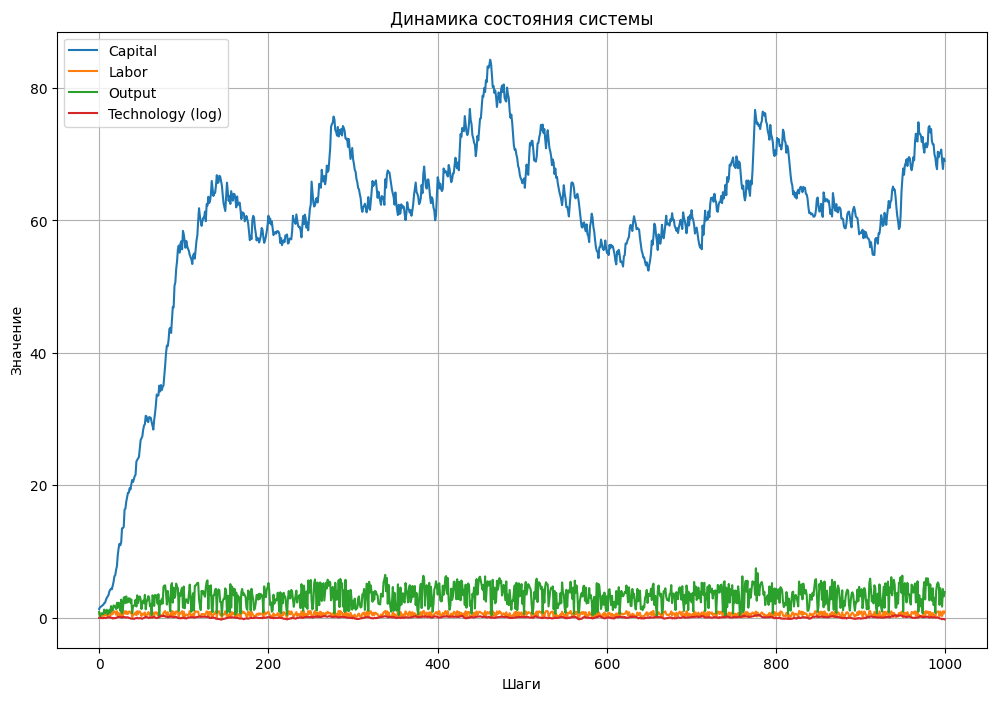

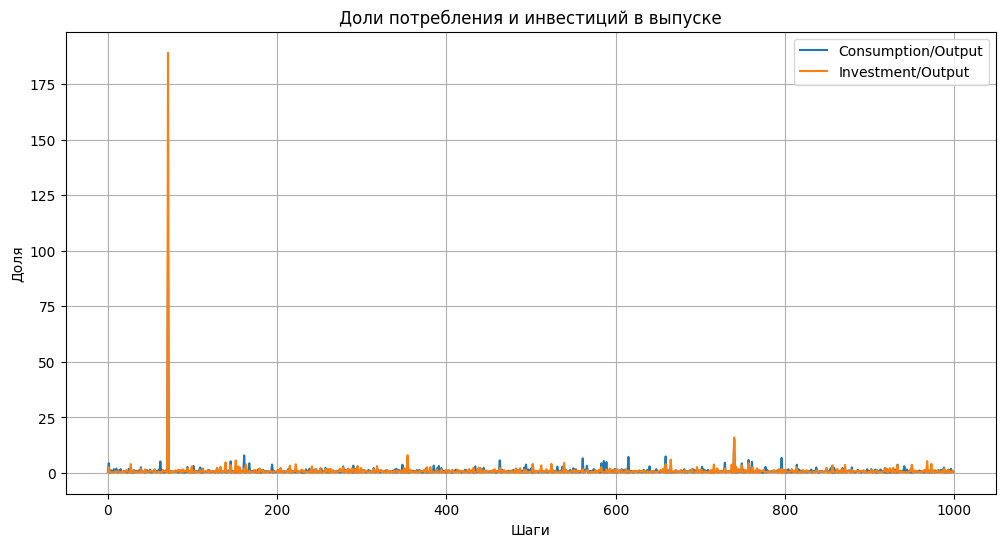

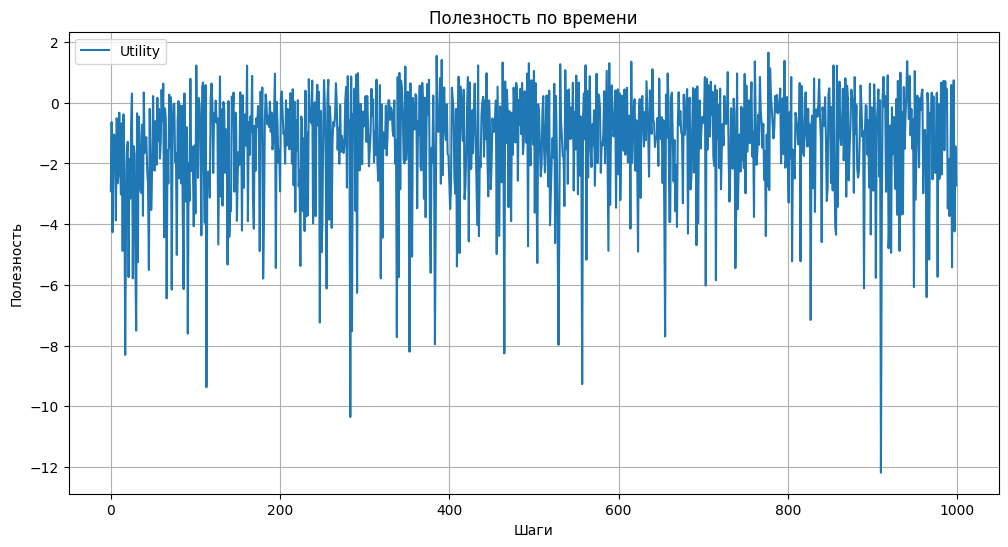

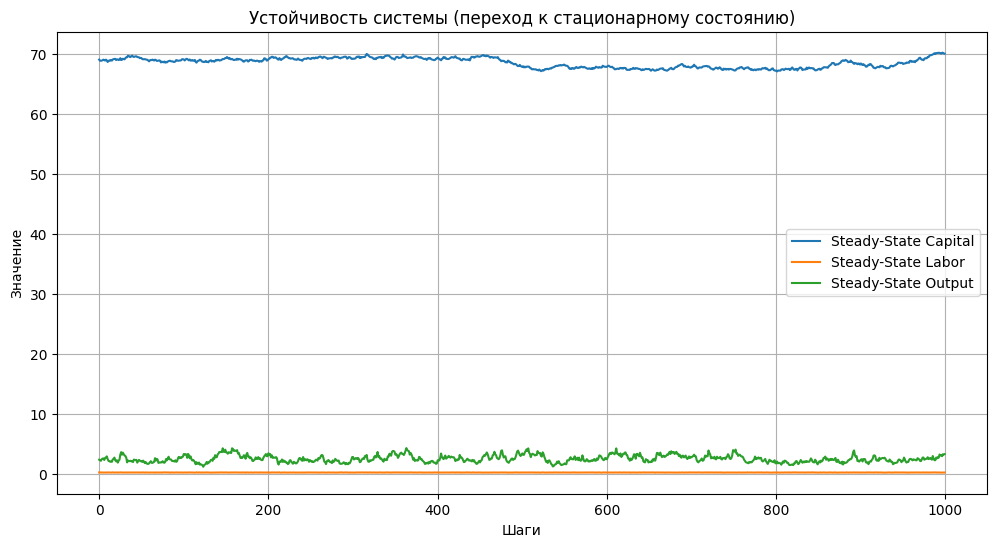

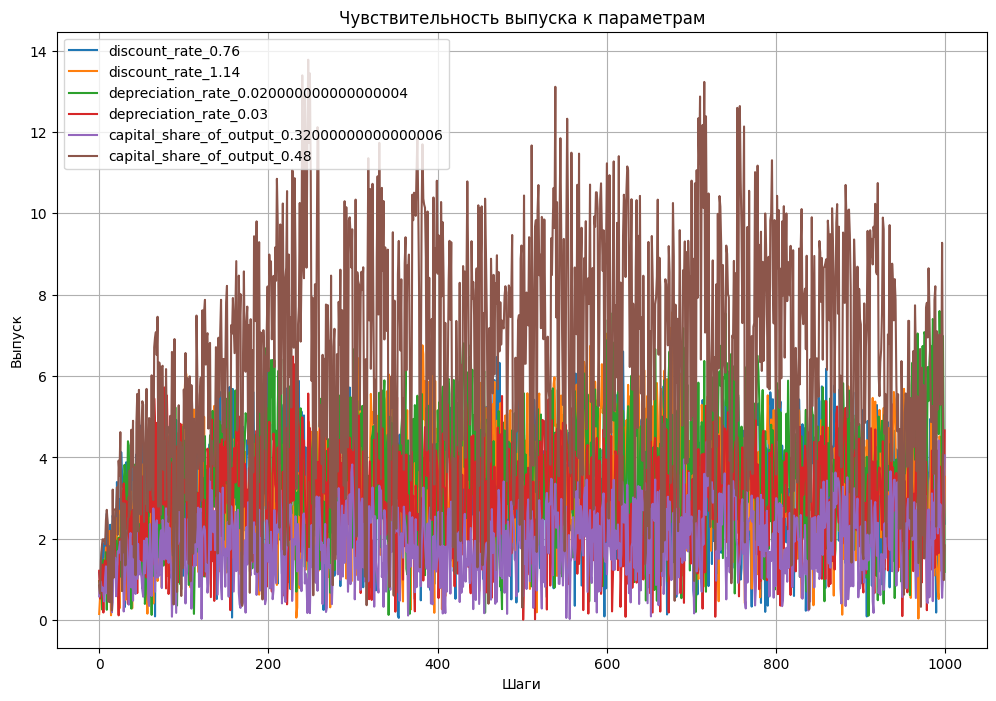

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

env = RBCEnv()
obs, _ = env.reset()
states, utilities, infos = [], [], []
steps = 1000

for _ in range(steps):
    action = env.action_space.sample()
    obs, reward, _, _, info = env.step(action)
    states.append(obs)
    utilities.append(reward)
    infos.append(info)


capital = np.array([s["Capital"][0] for s in states])
labor = np.array([s["Labor"][0] for s in states])
output = np.array([s["Output"][0] for s in states])
technology = np.array([s["Technology"][0] for s in states])
consumption = np.array([i["consumption"] for i in infos])
investment = np.array([i["investment"] for i in infos])


print("\nЭмпирические зависимости")
print(f"Корреляция (Output, Labor): {pearsonr(output, labor)[0]:.4f}")
print(f"Корреляция (Output, Investment): {pearsonr(output, investment)[0]:.4f}")
print(f"Корреляция (Output, Consumption): {pearsonr(output, consumption)[0]:.4f}")
print(f"Автокорреляция Output: {np.corrcoef(output[:-1], output[1:])[0, 1]:.4f}")

plt.figure(figsize=(12, 8))
plt.plot(capital, label="Capital")
plt.plot(labor, label="Labor")
plt.plot(output, label="Output")
plt.plot(technology, label="Technology (log)")
plt.title("Динамика состояния системы")
plt.xlabel("Шаги")
plt.ylabel("Значение")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(consumption / output, label="Consumption/Output")
plt.plot(investment / output, label="Investment/Output")
plt.title("Доли потребления и инвестиций в выпуске")
plt.xlabel("Шаги")
plt.ylabel("Доля")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(utilities, label="Utility")
plt.title("Полезность по времени")
plt.xlabel("Шаги")
plt.ylabel("Полезность")
plt.legend()
plt.grid()
plt.show()


steady_state_values = []
for _ in range(steps):
    obs, reward, _, _, info = env.analytical_step()
    steady_state_values.append(obs)

steady_capital = [s["Capital"][0] for s in steady_state_values]
steady_labor = [s["Labor"][0] for s in steady_state_values]
steady_output = [s["Output"][0] for s in steady_state_values]

plt.figure(figsize=(12, 6))
plt.plot(steady_capital, label="Steady-State Capital")
plt.plot(steady_labor, label="Steady-State Labor")
plt.plot(steady_output, label="Steady-State Output")
plt.title("Устойчивость системы (переход к стационарному состоянию)")
plt.xlabel("Шаги")
plt.ylabel("Значение")
plt.legend()
plt.grid()
plt.show()


sensitivity_results = {}
params_to_test = ["discount_rate", "depreciation_rate", "capital_share_of_output"]

for param in params_to_test:
    original_value = getattr(env, param)
    test_values = [original_value * 0.8, original_value * 1.2]

    for test_value in test_values:
        setattr(env, param, test_value)
        obs, _ = env.reset()

        temp_states = []
        for _ in range(steps):
            action = env.action_space.sample()
            obs, _, _, _, _ = env.step(action)
            temp_states.append(obs)

        temp_output = np.array([s["Output"][0] for s in temp_states])
        sensitivity_results[f"{param}_{test_value}"] = temp_output

    setattr(env, param, original_value)


plt.figure(figsize=(12, 8))
for param, values in sensitivity_results.items():
    plt.plot(values, label=param)
plt.title("Чувствительность выпуска к параметрам")
plt.xlabel("Шаги")
plt.ylabel("Выпуск")
plt.legend()
plt.grid()
plt.show()